In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RepeatedStratifiedKFold, RandomizedSearchCV
from scipy.stats import loguniform
from sklearn.metrics import accuracy_score, confusion_matrix
import warnings
from sklearn.metrics import mean_squared_error
import math

warnings.filterwarnings('ignore')
sns.set_theme(style='darkgrid')

def feature_stock_data(file_path):
    data = pd.read_csv(file_path)
    newfeatures = pd.DataFrame()
    newfeatures['Target'] = data['Close'].rolling(window=2).apply(lambda x: x.iloc[1] > x.iloc[0])
    newfeatures['Target'].fillna(0, inplace=True)
    data = data.shift(1)
    data['Target'] = newfeatures['Target']
    return data.iloc[1:]

def logistic_regression_analysis(data):
    # Predictors and Target
    predictors = ['Open', 'High', 'Low', 'Close', 'Volume']
    X_train, X_test, y_train, y_test = train_test_split(data[predictors], data['Target'], test_size=0.2, random_state=5)

    # Hyperparameter selection for Logistic Regression
    def select_hyperparameters_logistic_regression(X_train, y_train):
        model = LogisticRegression()
        space = {
            'solver': ['newton-cg', 'lbfgs', 'liblinear'],
            'penalty': ['none', 'l1', 'l2', 'elasticnet'],
            'C': loguniform(1e-5, 100)
        }
        cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
        search = RandomizedSearchCV(model, space, n_iter=500, scoring='accuracy', n_jobs=-1, cv=cv, random_state=1)
        result = search.fit(X_train, y_train)
        return result.best_params_

    # Logistic Regression with hyperparameters
    def logistic_regression_hyperparameter(X_train, y_train, X_test, y_test, params):
        model = LogisticRegression(C=params['C'], solver=params['solver'], penalty=params['penalty'])
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(pd.DataFrame(cm, columns=['Predicted:0', 'Predicted:1'], index=['Actual:0', 'Actual:1']), annot=True, fmt='d', cmap="YlGnBu")
        plt.show()
        # Tính toán RMSE
        rmse = math.sqrt(mean_squared_error(y_test, y_pred))
        return accuracy_score(y_test, y_pred), rmse

    best_params_lr = select_hyperparameters_logistic_regression(X_train, y_train)
    accuracy_logistic, rmse_logistic = logistic_regression_hyperparameter(X_train, y_train, X_test, y_test, best_params_lr)
    print("Logistic Regression Accuracy (default predictors):", round(accuracy_logistic * 100, 2), "%")
    print("Logistic Regression RMSE:", rmse_logistic)

def random_forest_analysis(data):
    # Predictors and Target
    predictors = ['Open', 'High', 'Low', 'Close', 'Volume']
    X_train, X_test, y_train, y_test = train_test_split(data[predictors], data['Target'], test_size=0.2, random_state=5)

    # Hyperparameter selection for Random Forest
    def select_hyperparameters_random_forest(X_train, y_train):
        model = RandomForestClassifier()
        space = {
            'n_estimators': [10, 100, 1000],
            'max_features': ['sqrt', 'log2']
        }
        cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
        search = RandomizedSearchCV(model, space, n_iter=500, scoring='accuracy', n_jobs=-1, cv=cv, random_state=1)
        result = search.fit(X_train, y_train)
        return result.best_params_

    # Random Forest with hyperparameters
    def random_forest_hyperparameter(X_train, y_train, X_test, y_test, params):
        model = RandomForestClassifier(n_estimators=params['n_estimators'], max_features=params['max_features'])
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(pd.DataFrame(cm, columns=['Predicted:0', 'Predicted:1'], index=['Actual:0', 'Actual:1']), annot=True, fmt='d', cmap="YlGnBu")
        plt.show()
        # Tính toán RMSE
        rmse = math.sqrt(mean_squared_error(y_test, y_pred))
        return accuracy_score(y_test, y_pred), rmse

    best_params_rf = select_hyperparameters_random_forest(X_train, y_train)
    accuracy_rf, rmse_rf = random_forest_hyperparameter(X_train, y_train, X_test, y_test, best_params_rf)
    print("Random Forest Accuracy (default predictors):", round(accuracy_rf * 100, 2), "%")
    print("Random Forest RMSE:", rmse_rf)



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Input
import math

# Data preparation function
def feature_stock_data(file_path):
    data = pd.read_csv(file_path)
    newfeatures = pd.DataFrame()
    newfeatures['Target'] = data['Close'].rolling(window=2).apply(lambda x: x.iloc[1] > x.iloc[0])
    newfeatures['Target'].fillna(0, inplace=True)
    data = data.shift(1)
    data['Target'] = newfeatures['Target']
    return data.iloc[1:]

# Prepare data for LSTM
def prepare_lstm_data(data, predictors, time_steps=7):
    X, y = [], []
    for i in range(time_steps, len(data)):
        X.append(data[predictors].iloc[i-time_steps:i].values)
        y.append(data['Target'].iloc[i])
    return np.array(X), np.array(y)

# Improved LSTM model function
def lstm_model_analysis(data):
    predictors = ['Open', 'High', 'Low', 'Close', 'Volume']
    time_steps = 7
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data[predictors])

    data[predictors] = scaled_data
    X, y = prepare_lstm_data(data, predictors, time_steps)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)

    # LSTM Model
    model = Sequential()
    model.add(Input(shape=(60, 1), dtype='float32')) # input_shape = (timesteps, features)
    # layer 1
    model.add(LSTM(30, return_sequences=True, activation='relu'))
    model.add(Dropout(0.1))
    # layer 2
    model.add(LSTM(40, return_sequences=True, activation='relu'))
    model.add(Dropout(0.1))
    # layer 3
    model.add(LSTM(50, return_sequences=True, activation='relu'))
    model.add(Dropout(0.1))
    # layer 4
    model.add(LSTM(60, activation='relu'))
    model.add(Dropout(0.1))

    model.add(Dense(units=1))

    model.compile(optimizer='adam',loss='mean_squared_error')

    # Train the model
    model.fit(X_train, y_train, epochs=15, batch_size=8)

    # Predictions
    y_pred = (model.predict(X_test) > 0.5).astype("int32")

    # Confusion matrix and accuracy
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(pd.DataFrame(cm, columns=['Predicted:0', 'Predicted:1'], index=['Actual:0', 'Actual:1']), annot=True, fmt='d', cmap="YlGnBu")
    plt.show()

    # Calculate metrics
    rmse = math.sqrt(mean_squared_error(y_test, y_pred))
    accuracy = accuracy_score(y_test, y_pred)
    
    print("LSTM Model Accuracy:", round(accuracy * 100, 2), "%")
    print("LSTM Model RMSE:", rmse)


Epoch 1/15
224/224 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.2904
Epoch 2/15
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.2561
Epoch 3/15
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.2505
Epoch 4/15
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.2522
Epoch 5/15
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.2513
Epoch 6/15
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.2529
Epoch 7/15
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.2511
Epoch 8/15
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.2519
Epoch 9/15
224/224 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.2538
Epoch 10/15
224/224 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.2501
Epoch 11/15
224/224 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.2530
Epoch 12/15
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.2493
Epoch 13/15
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.2481
Epoch 14/15
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.2490
Epoch 15/15
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - lo

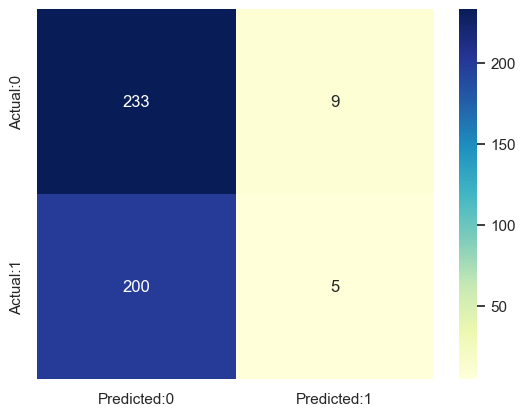

LSTM Model Accuracy: 53.24 %
LSTM Model RMSE: 0.6837847038745429


In [20]:
data = feature_stock_data('../clean_data/clean_dataAAPL.csv')
# logistic_regression_analysis(data)
# random_forest_analysis(data)
lstm_model_analysis(data)
# prophet_model_analysis(data)

In [ ]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt

# Load your stock data
# Make sure your CSV file has columns 'Date' and 'Close'
df = pd.read_csv('../clean_data/clean_dataAAPL.csv')

# Convert Date column to datetime format and remove timezone information
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')

# Print data types to verify conversion
print(df.dtypes)

# Check for any conversion issues
print(df.head())

# Rename columns to match Prophet's expected format
df.rename(columns={'Date': 'ds', 'Close': 'y'}, inplace=True)

# Ensure there are no NaT values after conversion
df = df.dropna(subset=['ds'])

# Initialize the Prophet model
model = Prophet()

# Fit the model
model.fit(df)

# Create a dataframe for future dates
future = model.make_future_dataframe(periods=365)  # Predicting 1 year into the future

# Make predictions
forecast = model.predict(future)

# Plot the forecast
fig1 = model.plot(forecast)
plt.show()

# Plot the forecast components
fig2 = model.plot_components(forecast)
plt.show()
